# <img src="https://img.icons8.com/dusk/64/000000/artificial-intelligence.png" style="height:50px;display:inline"> EE 046202 - Technion - Unsupervised Learning & Data Analysis
---

#### <a href="https://taldatech.github.io">Tal Daniel</a>

## Tutorial 09 - Deep Unsupervised Learning - Variational Autoencoder (VAE) - Part 2

---

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---

* [Recap](#-Recap)
* [Implementation in PyTorch](#-VAE-Implementation)
    * [Architecture](#-VAE-Implementation)
    * [Reparameterization Trick](#-The-Reparameterization-Trick)
    * [Encoder](#-Encoder)
    * [Decoder](#-Decoder)
    * [Assembling the VAE](#-VAE,-Assemble!-(Putting-It-All-Together))
    * [Loss Function](#-The-Loss-Function)
* [Example on MNIST](#-Example---VAE-On-The-MNIST-Dataset)
    * [Interpolation in the Latent Space](#-Interpolation-in-the-Latent-Space)
    * [t-SNE on the Latent Space](#-Latent-Space-Representation-with-t-SNE)
* [Recommended Videos](#-Recommended-Videos)
* [Credits](#-Credits)

In [1]:
# imports for the tutorial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision

# sklearn imports
from sklearn.manifold import TSNE

## <img src="https://img.icons8.com/dusk/64/000000/rewind.png" style="height:50px;display:inline"> Recap
---
#### Notations
---
1. $X$ - the data we want to model (e.g. images of dogs)
2. $z$ - the latent variable (this is the *imagination*, the hidden variable that describes the data, we have seen this before)
3. $p_{\theta}(X)$ - the parameterized probability distribution of the data (e.g. the distribution of all dogs' images in the world). Also, the **evidence**.
4. $p(z)$ - the probability distribution of the latent variables (the source of the imagination, the brain in this case or the distribution of dogs' images feaures/hidden representations). The **prior**.
5. $p_{\theta}(X|z)$ - the parameterized distribution of data generation **given latent variable** (given the features we want the dog to have, the probability of images that satisfy these conditions, turning imagination to real image). The **likelihood** (remember MLE?).
6. $p_{\theta}(z|X)$ - the parameterized distribution of latent variables **given data** (given the image of dog, the probability of latent features that satisfy this image). The **posterior**.

#### Objective
----
* The optimization problem: make the simpler distribution, $q_{\phi}(z|X)$ as closer as possible to $p_{\theta}(z|X)$.
* The **KL-divergence** is formulated as follows: $$ D_{KL}[q_{\phi}(z|X) || p_{\theta}(z|X)] = \mathbb{E}_{q_{\phi}(z|X)}[\log \frac{q_{\phi}(z|X)}{p_{\theta}(z|X)}]  $$
    * $\mathbb{E}_{q_{\phi}(z|X)}[\log \frac{q_{phi}(z|X)}{p_{\theta}(z|X)}] = \sum_z q_{phi}(z|X) \log\frac{q_{\phi}(z|X)}{p_{\theta}(z|X)} $
$$\mathbb{E}_{q_{\phi}(z|X)}[\log \frac{q_{\phi}(z|X)}{p_{\theta}(z|X)}] =  \mathbb{E}_{q_{\phi}(z|X)}[\log q_{\phi}(z|X) - \log p_{\theta}(z|X)]$$

Using **Bayes' Rule**:

$$\rightarrow D_{KL}[q_{\phi}(z|X) || p_{\theta}(z|X)] =  \mathbb{E}_{q_{\phi}(z|X)}[\log q_{\phi}(z|X) - \log \frac{p_{\theta}(X|z)p(z)}{p_{\theta}(X)}]$$ $$ = \mathbb{E}_{q_{\phi}(z|X)}[\log q_{\phi}(z|X) - (\log p_{\theta}(X|z) + \log p(z) - \log p_{\theta}(X))] $$ $$ = \mathbb{E}_{q_{\phi}(z|X)}[\log q_{\phi}(z|X) -\log p_{\theta}(X|z) - \log p(z) + \log p_{\theta}(X))] $$

* Notice that the expecation is over $z$ and $p_{\theta}(X)$ does not depend on $z$:

$$\rightarrow  D_{KL}[q_{\phi}(z|X) || p_{\theta}(z|X)] = \mathbb{E}_{q_{\phi}(z|X)}[\log q_{\phi}(z|X) -\log p_{\theta}(X|z) - \log p(z)] + \log p_{\theta}(X)$$ $$ \log p_{\theta}(X) \geq \mathbb{E}_{q_{\phi}(z|X)}[\log p_{\theta}(X|z)] - D_{KL}[q_{\phi}(z|X) || p(Z)] = ELBO $$

* **Loss Function**: $$ \mathcal{L}_{VAE} = -ELBO(x;\phi, \theta) = -\mathbb{E}_{q_{\phi}(z|X)}[\log p_{\theta}(X|z)] + D_{KL}[q_{\phi}(z|X)|| p(z)]  $$
* **KL-Divergence Closed-form Solution**: 
    * Having:
        * $z \sim \mathcal{N}(0,1)$
        * $z|X \sim \mathcal{N}(\mu(X), \Sigma(X))$

        $$ D_{KL}[q_{\phi}(z|X)|| p_{\theta}(z)] = \frac{1}{2}\sum_{i=1}^d[\Sigma(X)_{ii} +\mu(X)_i^2 -1 -\log \Sigma(X)_{ii}] $$
*  **Reconstruction Loss**: $\mathbb{E}_{q_{\phi}(z|X)}[\log p_{\theta}(X|z)]$ - this is also called the **log-likelihood** of $X$ under $z$. Maximizing the likelihood is a well-known concept from Machine Learning course, as **Maximum Likelihood Estimation (MLE)**. You have seen this many times in *supervised* learning settings like *Linear Regression* or *Logistic Regression*. Maximizing the likelihood is equivalent to *minimizing* the **negative log-likelihood** (NLL).

<img src="./assets/vae_lilian_weng.png" style="height:300px">

* <a href="https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#beta-vae">Image by Lilian Weng</a>

### <img src="https://img.icons8.com/color/96/000000/code.png" style="height:50px;display:inline"> VAE Implementation
---
We will now implement the VAE components using PyTorch. The general structure of the network: 
<img src='./assets/tut_xv_nn_arch.png' style="height:400px">
And remember that we need to implement the **reparameterization trick**:
<img src='./assets/tut_xv_reparameter.png' style="height:300px">

* Note: we are going to use a simple architecture since we are going to work with a simple dataset, but more difficult datasets require more complex architectures that use convolutional layers, batch normalization layers and etc...

#### <img src="https://img.icons8.com/office/80/000000/magic-lamp.png" style="height:30px;display:inline"> The Reparameterization Trick
---
We will first implement a function that takes the mean $\mu(x)$ and the variance $\Sigma(X)$ and outputs $z \sim \mathcal{N}(\mu(X), \Sigma(X))$ using the reparemeterization trick so that we can backpropagate the gradients.

In [2]:
# reparametrization trick
def reparameterize(mu, logvar, device=torch.device("cpu")):
    """
    This function applies the reparameterization trick:
    z = mu(X) + sigma(X)^0.5 * epsilon, where epsilon ~ N(0,I)
    :param mu: mean of x
    :param logvar: log variance of x
    :param device: device to perform calculations on
    :return z: the sampled latent variable
    """
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std).to(device)
    return mu + eps * std

#### <img src="https://img.icons8.com/dusk/64/000000/lock-2.png" style="height:30px;display:inline"> Encoder
---
* The encoder takes the high-dimensional data, $X \in \mathcal{R}^D$, and encodes in a lower-dimensional latent space vector, $z \in \mathcal{R}^d$, that is, we model $q_{\phi}(z|X)$. 
* Since we are in a *variational* environment, and we model a distrubution $q_{\phi}$, the outputs of the encoder are the mean, $\mu(X) \in \mathcal{R}^d$ and the co-variance, $\Sigma(X) \in \mathcal{R}^d$. 
    * Remember that since we assume independce between the latent variables, the co-variance matrix is diagonal and we can represent it as a vector in $\mathcal{R}^d$, where each value represents the variance (the $ii^{th}$ element in the co-variance matrix).

In [3]:
# encoder - q_{\phi}(z|X)
class VaeEncoder(torch.nn.Module):
    """
       This class builds the encoder for the VAE
       :param x_dim: input dimensions
       :param hidden_size: hidden layer size
       :param z_dim: latent dimensions
       :param device: cpu or gpu
       """

    def __init__(self, x_dim=28*28, hidden_size=256, z_dim=10, device=torch.device("cpu")):
        super(VaeEncoder, self).__init__()
        self.x_dim = x_dim
        self.hidden_size = hidden_size
        self.z_dim = z_dim
        self.device = device
        
        self.features = nn.Sequential(nn.Linear(x_dim, self.hidden_size),
                                      nn.ReLU())
        
        self.fc1 = nn.Linear(self.hidden_size, self.z_dim, bias=True)  # fully-connected to output mu
        self.fc2 = nn.Linear(self.hidden_size, self.z_dim, bias=True)  # fully-connected to output logvar


    def bottleneck(self, h):
        """
        This function takes features from the encoder and outputs mu, log-var and a latent space vector z
        :param h: features from the encoder
        :return: z, mu, log-variance
        """
        mu, logvar = self.fc1(h), self.fc2(h)
        # use the reparametrization trick as torch.normal(mu, logvar.exp()) is not differentiable
        z = reparameterize(mu, logvar, device=self.device)
        return z, mu, logvar

    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        z, mu, logvar = VaeEncoder(X)
        """
        h = self.features(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

#### <img src="https://img.icons8.com/dusk/64/000000/unlock-2.png" style="height:30px;display:inline"> Decoder
---
* The decoder takes a lower-dimensional latent space vector, $z \in \mathcal{R}^d$ and decodes it to a high-dimensional *reconstruction* data, $\tilde{X} \in \mathcal{R}^D$ , that is, we model $p_{\theta}(X|z)$. 

In [4]:
# decoder - p_{\theta}(x|z)
class VaeDecoder(torch.nn.Module):
    """
       This class builds the decoder for the VAE
       :param x_dim: input dimensions
       :param hidden_size: hidden layer size
       :param z_dim: latent dimensions
       """

    def __init__(self, x_dim=28*28, hidden_size=256, z_dim=10):
        super(VaeDecoder, self).__init__()
        self.x_dim = x_dim
        self.hidden_size = hidden_size
        self.z_dim = z_dim
        
        self.decoder = nn.Sequential(nn.Linear(self.z_dim, self.hidden_size),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_size, self.x_dim),
                                     nn.Sigmoid())
        # why we use sigmoid? becaue the pixel values of images are in [0,1] and sigmoid(x) does just that!
        # however, you don't have to use that (see what happens without it).


    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        x_reconstruction = VaeDecoder(z)
        """
        x = self.decoder(x)
        return x

#### <img src="https://img.icons8.com/officel/80/000000/avengers.png" style="height:30px;display:inline"> VAE, Assemble! (Putting It All Together)
---
We now want to have an end-to-end encoder-decoder model that does everything with one line of code, and we also want the ability to generate new samples (that is, sample a random vector from the unit normal distribution and decode it - without encoding!).

In [5]:
class Vae(torch.nn.Module):
    def __init__(self, x_dim=28*28, z_dim=10, hidden_size=256, device=torch.device("cpu")):
        super(Vae, self).__init__()
        self.device = device
        self.z_dim = z_dim

        self.encoder = VaeEncoder(x_dim, hidden_size, z_dim=z_dim, device=device)
        self.decoder = VaeDecoder(x_dim, hidden_size, z_dim=z_dim)

    def encode(self, x):
        z, mu, logvar = self.encoder(x)
        return z, mu, logvar

    def decode(self, z):
        x = self.decoder(z)
        return x

    def sample(self, num_samples=1):
        """
        This functions generates new data by sampling random variables and decoding them.
        Vae.sample() actually generates new data!
        Sample z ~ N(0,1)
        """
        z = torch.randn(num_samples, self.z_dim).to(self.device)
        return self.decode(z)

    def forward(self, x):
        """
        This is the function called when doing the forward pass:
        return x_recon, mu, logvar, z = Vae(X)
        """
        z, mu, logvar = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z

#### <img src="https://img.icons8.com/dusk/64/000000/bearish.png" style="height:30px;display:inline"> The Loss Function
---
The loss function is composed of the *reconstruction loss* and the *KL-divergence*: 
$$ \mathcal{L}_{VAE} = -\mathbb{E}_{q_{\phi}(z|X)}[\log p_{\theta}(X|z)] + D_{KL}[q_{\phi}(z|X)|| p(z)] = ReconLoss(\tilde{x}, x) +  \frac{1}{2}\sum_{i=1}^d[\Sigma(X)_{ii} +\mu(X)_i^2 -1 -\log \Sigma(X)_{ii}]$$

* **Reconstruction Loss**:
    * For images, we will use <a href="https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy">Binary Cross Entropy (BCE) </a>, as the values of the pixels are between [0,1] (normalized). There are other alternatives, like "perceptual loss", MSE or MAE (see below).
    * For continuous inputs, we can use $L_1$ (MAE) or $L_2$ (MSE). 

In [6]:
def loss_function(recon_x, x, mu, logvar, loss_type='bce'):
    """
    This function calculates the loss of the VAE.
    loss = reconstruction_loss - 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param recon_x: the reconstruction from the decoder
    :param x: the original input
    :param mu: the mean given X, from the encoder
    :param logvar: the log-variance given X, from the encoder
    :param loss_type: type of loss function - 'mse', 'l1', 'bce'
    :return: VAE loss
    """
    if loss_type == 'mse':
        recon_error = F.mse_loss(recon_x, x, reduction='sum')
    elif loss_type == 'l1':
        recon_error = F.l1_loss(recon_x, x, reduction='sum')
    elif loss_type == 'bce':
        recon_error = F.binary_cross_entropy(recon_x, x, reduction='sum')
    else:
        raise NotImplementedError

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_error + kl) / x.size(0)  # normalize by batch_size

### <img src="https://img.icons8.com/bubbles/50/000000/hand-with-pen.png" style="height:50px;display:inline"> Example - VAE On The MNIST Dataset
----
The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.
We will now build the training loop of the VAE and learn an approximation to the hand-written digits distribution.

In [7]:
# let's load the dataset and see some examples

# in order to create batches of the data, we create a Dataset and a DataLoader, which takes care of:
# 1. pre-processing the images to tensors with values in [0,1]
# 2. shuffling the data, so we add randomness as learned in ML
# 3. if the data size is not divisible by the batch size, we can drop the last batch 
# (so the batches are always of the same size)

# define pre-procesing transformation to use
transform = torchvision.transforms.ToTensor()

train_data = torchvision.datasets.MNIST('./datasets/', train=True, transform=transform,
                                        target_transform=None, download=True)
test_data = torchvision.datasets.MNIST('./datasets/', train=False, transform=transform,
                                       target_transform=None, download=True)



sample_dataloader = DataLoader(train_data, batch_size=6, shuffle=True, drop_last=True)

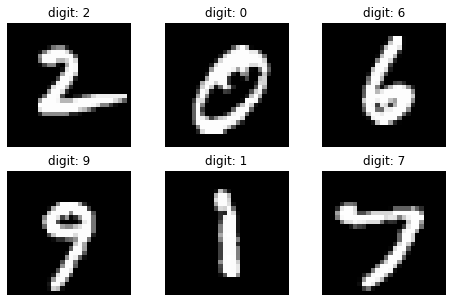

In [8]:
fig = plt.figure(figsize=(8 ,5))
samples, labels = next(iter(sample_dataloader))
for i in range(samples.size(0)):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(samples[i][0, :, :].data.cpu().numpy(), cmap='gray')
    title = "digit: " + str(labels[i].data.cpu().item())
    ax.set_title(title)
    ax.set_axis_off()

#### <img src="https://img.icons8.com/dusk/50/000000/exercise.png" style="height:30px;display:inline"> The VAE Training Loop
---
We will now build the training loop of the VAE in PyTorch. Pay attention to the order of each function, it is very important in PyTorch.

In [9]:
# define hyper-parameters
BATCH_SIZE = 128  # usually 32/64/128/256
LEARNING_RATE = 1e-3  # for the gradient optimizer
NUM_EPOCHS = 150  # how many epochs to run?
HIDDEN_SIZE = 256  # size of the hidden layers in the networks
X_DIM = 28 * 28  # size of the input dimension
Z_DIM = 10  # size of the latent dimension

In [10]:
# training

# check if there is gpu avilable, if there is, use it
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print("running calculations on: ", device)

# load the data
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# create our model and send it to the device (cpu/gpu)

vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)

# optimizer 
vae_optim = torch.optim.Adam(params=vae.parameters(), lr=LEARNING_RATE)

# save the losses from each epoch, we might want to plot it later
train_losses = []

# here we go
for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    batch_losses = []
    for batch_i, batch in enumerate(dataloader):
        # forward pass
        x = batch[0].to(device).view(-1, X_DIM)  # just the images
        x_recon, mu, logvar, z = vae(x)
        # calculate the loss
        loss = loss_function(x_recon, x, mu, logvar, loss_type='bce')
        # optimization (same 3 steps everytime)
        vae_optim.zero_grad()
        loss.backward()
        vae_optim.step()
        # save loss
        batch_losses.append(loss.data.cpu().item())
    train_losses.append(np.mean(batch_losses))
    print("epoch: {} training loss: {:.5f} epoch time: {:.3f} sec".format(epoch, train_losses[-1],
                                                                          time.time() - epoch_start_time))

running calculations on:  cuda:0
epoch: 0 training loss: 171.84777 epoch time: 7.842 sec
epoch: 1 training loss: 128.69239 epoch time: 7.625 sec
epoch: 2 training loss: 122.78445 epoch time: 7.774 sec
epoch: 3 training loss: 119.74014 epoch time: 7.808 sec
epoch: 4 training loss: 117.81168 epoch time: 7.726 sec
epoch: 5 training loss: 116.45555 epoch time: 7.780 sec
epoch: 6 training loss: 115.35806 epoch time: 7.660 sec
epoch: 7 training loss: 114.56222 epoch time: 7.645 sec
epoch: 8 training loss: 113.82657 epoch time: 7.708 sec
epoch: 9 training loss: 113.21288 epoch time: 7.673 sec
epoch: 10 training loss: 112.67187 epoch time: 7.772 sec
epoch: 11 training loss: 112.20706 epoch time: 7.669 sec
epoch: 12 training loss: 111.83337 epoch time: 7.681 sec
epoch: 13 training loss: 111.46434 epoch time: 7.642 sec
epoch: 14 training loss: 111.14702 epoch time: 7.829 sec
epoch: 15 training loss: 110.86055 epoch time: 7.660 sec
epoch: 16 training loss: 110.57215 epoch time: 7.662 sec
epoch: 1

In [11]:
# saving our model (so we don't have to train it again...)
# this is one of the greatest things in pytorch - saving and loading models

# save
fname = "./vae_mnist_" + str(NUM_EPOCHS) + "_epochs.pth"
torch.save(vae.state_dict(), fname)
print("saved checkpoint @", fname)

saved checkpoint @ ./vae_mnist_150_epochs.pth


In [16]:
# load
vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
vae.load_state_dict(torch.load(fname))
print("loaded checkpoint from", fname)

loaded checkpoint from ./vae_mnist_150_epochs.pth


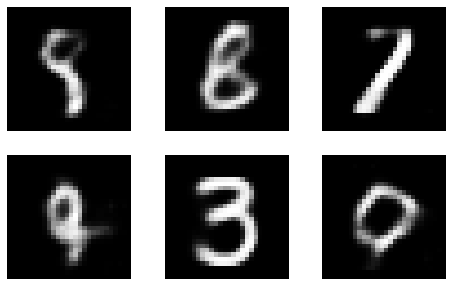

In [20]:
# now let's sample from the vae
n_samples = 6
vae_samples = vae.sample(num_samples=n_samples).view(n_samples, 28, 28).data.cpu().numpy()
fig = plt.figure(figsize=(8 ,5))
for i in range(vae_samples.shape[0]):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(vae_samples[i], cmap='gray')
    ax.set_axis_off()

#### <img src="https://img.icons8.com/officel/80/000000/one-way-transition.png" style="height:30px;display:inline"> Interpolation in the Latent Space
---
Let's have some fun!

We will take two images, encode them using our VAE and by doing interpolation: $$ z_{new} = \alpha z_1 + (1-\alpha) z_2, \alpha \in [0,1] $$ we will see the transition between the 2 images.

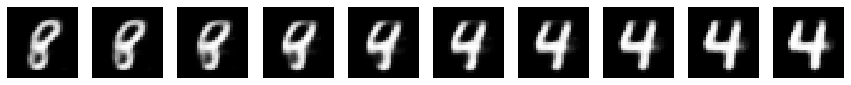

In [21]:
# let's do something fun - interpolation of the latent space
alphas = np.linspace(0.1, 1, 10)
# take 2 samples
sample_dataloader = DataLoader(test_data, batch_size=2, shuffle=True, drop_last=True)
it = iter(sample_dataloader)
samples, labels = next(it)
while labels[0] == labels[1]:
    # make sure they are different digits
    samples, labels = next(it)
x_1, x_2 = samples

# get their latent representation
_,_, _, z_1 = vae(x_1.view(-1, X_DIM).to(device))
_,_, _, z_2 = vae(x_2.view(-1, X_DIM).to(device))

# let's see the result
fig = plt.figure(figsize=(15 ,8))
for i, alpha in enumerate(alphas):
    z_new = alpha * z_1 + (1 - alpha) * z_2
    x_new = vae.decode(z_new)
    ax = fig.add_subplot(1, 10, i + 1)
    ax.imshow(x_new.view(28, 28).cpu().data.numpy(), cmap='gray')
    ax.set_axis_off()

#### <img src="https://img.icons8.com/color/96/000000/3d-glasses.png" style="height:30px;display:inline"> Latent Space Representation with t-SNE
---
Let's see how descriptive is the latent space. We will take 2000 images, decode them, and reduce their dimensionality with t-SNE.

Text(0.5, 1.0, 't-SNE of VAE Latent Space on MNIST')

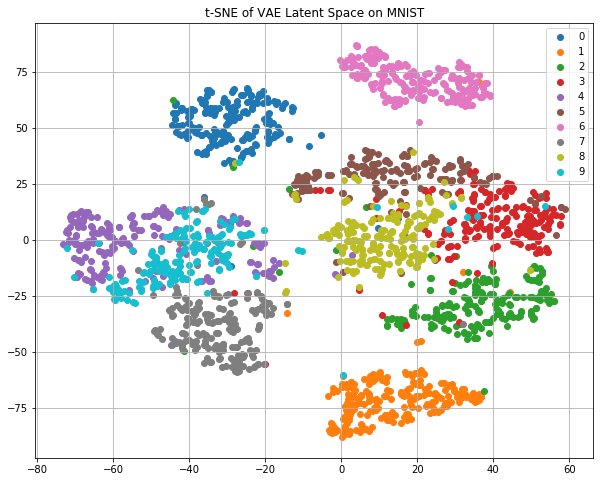

In [15]:
# take 2000 samples
num_samples = 2000
sample_dataloader = DataLoader(train_data, batch_size=num_samples, shuffle=True, drop_last=True)
samples, labels = next(iter(sample_dataloader))

labels = labels.data.cpu().numpy()
# decode the samples
_,_, _, z = vae(samples.view(num_samples, X_DIM).to(device))

# t-SNE
perplexity = 15.0
t_sne = TSNE(n_components=2, perplexity=perplexity)
z_embedded = t_sne.fit_transform(z.data.cpu().numpy())

# plot
fig = plt.figure(figsize=(10 ,8))
ax = fig.add_subplot(1, 1, 1)
for i in np.unique(labels):
    ax.scatter(z_embedded[labels==i,0], z_embedded[labels==i, 1], label=str(i))
ax.legend()
ax.grid()
ax.set_title("t-SNE of VAE Latent Space on MNIST")

### <img src="https://img.icons8.com/bubbles/50/000000/video-playlist.png" style="height:50px;display:inline"> Recommended Videos
---
#### <img src="https://img.icons8.com/cute-clipart/64/000000/warning-shield.png" style="height:30px;display:inline"> Warning!
* These videos do not replace the lectures and tutorials.
* Please use these to get a better understanding of the material, and not as an alternative to the written material.

#### Video By Subject

* Variational Inference (VI) - <a href="https://www.youtube.com/watch?v=2pEkWk-LHmU">Machine Learning: Variational Inference</a>
    * Until 13:30 mins
* Analyzing the KL-Divergence in VI - <a href="https://www.youtube.com/watch?v=uKxtmkfeuxg">Variational Inference Part 2 (KL divergence)</a>
* Generative Models (VAEs + GANs) - <a href="https://www.youtube.com/watch?v=5WoItGTWV54">Standord CS231n - Lecture 13 | Generative Models</a>

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Deep Learning - Unsupervised Learning, <a href="https://www.cs.cmu.edu/~rsalakhu/talk_MLSS_part2.pdf"> Tutorial by Ruslan Salakhutdinov (CMU) </a> - https://www.cs.cmu.edu/~rsalakhu/
* <a href="https://sites.google.com/view/berkeley-cs294-158-sp19/home"> CS294-158 Deep Unsupervised Learning Spring 2019 </a> @ UC Berkeley - https://sites.google.com/view/berkeley-cs294-158-sp19/home
* <a href="https://jeremyjordan.me/variational-autoencoders/"> Variational autoencoders. </a> by Jeremy Jordan - https://jeremyjordan.me
* <a href="https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/">Variational Autoencoder: Intuition and Implementation </a> by Agustinus Kristiadi
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com
* Datasets from <a href="https://www.kaggle.com/">Kaggle</a> - https://www.kaggle.com/